In [1]:
%load_ext autoreload
%autoreload 2

## Настройка окружения

In [2]:
%pip install --upgrade pip -q

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [3]:
%pip install git+https://github.com/OPR-Project/OpenPlaceRecognition.git -q


[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [4]:
%pip install -r ../requirements.txt -q


[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [5]:
from pathlib import Path
import shutil
import cv2
import albumentations as A

import torchshow as ts
import torch
from torch import Tensor
from tqdm.notebook import tqdm
import pandas as pd

import opr
import numpy as np
import faiss

from opr.models.place_recognition import (
    NetVLADModel, 
    BoQModel, 
    SequenceLateFusionModel
)
from opr.modules.temporal import (
    TemporalAveragePooling,
    TemporalAttentionFusion,
    TemporalSelfAttentionFusion,
    TemporalLSTMFusion,
)
from opr.pipelines.place_recognition.sequential import SequencePlaceRecognitionPipeline

import warnings
warnings.filterwarnings("ignore")

INFO:faiss.loader:Loading faiss with AVX2 support.
INFO:faiss.loader:Successfully loaded faiss with AVX2 support.
2025-07-03 09:10:28.327 | WARNING  | opr.optional_deps:warn_once:115 - MinkowskiEngine is not available. sparse convolutions will be disabled. See the documentation for installation instructions
2025-07-03 09:10:31.853 | WARNING  | opr.modules.svt:<module>:22 - MinkowskiEngine is not installed. Some features may not be available.
2025-07-03 09:10:33.244 | WARNING  | opr.modules.feature_extractors.mink_resnet:<module>:23 - MinkowskiEngine is not installed. Some features may not be available.
2025-07-03 09:10:33.261 | WARNING  | opr.modules.feature_extractors.svtnet:<module>:26 - MinkowskiEngine is not installed. Some features may not be available.
2025-07-03 09:10:33.290 | WARNING  | opr.optional_deps:warn_once:115 - polygraphy is not available. TensorRT will be disabled. See the documentation for installation instructions
2025-07-03 09:10:33.291 | WARNING  | opr.optional_de

In [6]:
print(f"PyTorch version: {torch.__version__}, cuda: {torch.cuda.is_available()}")
print(f"OpenPlaceRecognition version: {opr.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"FAISS version: {faiss.__version__}")

PyTorch version: 2.0.1+cu118, cuda: True
OpenPlaceRecognition version: 0.2.1
NumPy version: 1.26.4
FAISS version: 1.7.4


## Загрузка данных из S3

Используйте предоставленный скрипт: `python ../scripts/download_data.py --help` (рекомендуется запускать в отдельном терминале, а не в ноутбуке)

Или, например, перенесите код из скрипта и адаптируйте его под себя, если необходимо.

## Константы

In [7]:
REPO_ROOT = Path.cwd().parent
print(f"Repository root dir: {REPO_ROOT}")

DATA_DIR = REPO_ROOT / "data"
assert DATA_DIR.exists(), f"Data directory {DATA_DIR} does not exist. Please run the download script."
print(f"Data dir: {DATA_DIR}")

SUBMISSIONS_DIR = REPO_ROOT / "submissions"
SUBMISSIONS_DIR.mkdir(exist_ok=True, parents=True)
print(f"Submissions dir: {SUBMISSIONS_DIR}")

Repository root dir: /home/jupyter/work/resources/iprofihack2025_phystech_cartography
Data dir: /home/jupyter/work/resources/iprofihack2025_phystech_cartography/data
Submissions dir: /home/jupyter/work/resources/iprofihack2025_phystech_cartography/submissions


## Чтение данных

Создадим DataReader для чтения данных с диска.

Ключевые моменты:
- `__getitem__` возвращает словарь с ключами:
  - `pose`: координаты в формате `[x, y]`
  - `image_front_cam`: изображение передней камеры (если указан аргумент `front_cam=True`)
  - `image_back_cam`: изображение задней камеры (если указан аргумент `back_cam=True`)
- `collate_fn` объединяет данные в батчи в нужном для OPR формате: словарь с ключами `poses`, `images_<camera_name>`, ...

In [8]:
class ITLPTrackDataReader:
    def __init__(
        self,
        root: Path,
        image_transform: A.Compose,
        front_cam: bool = True,
        back_cam: bool = False
    ):
        self._root = Path(root)
        self._front_cam_dir = self._root / "front_cam"
        self._back_cam_dir = self._root / "back_cam"

        self._track_df = pd.read_csv(self._root / "track.csv")
        # note that we use albumentations for image transformations
        self._image_transform = image_transform
        self._front_cam = front_cam
        self._back_cam = back_cam
        if not self._front_cam and not self._back_cam:
            raise ValueError("At least one camera must be enabled: front_cam or back_cam.")

    def __len__(self) -> int:
        return len(self._track_df)

    def __getitem__(self, idx: int) -> dict[str, Tensor]:
        pose = self._track_df[["tx", "ty"]].iloc[idx].to_numpy()
        front_cam_path = (self._front_cam_dir 
                          / f"{self._track_df['front_cam_ts'].iloc[idx]}.jpg")
        back_cam_path = (self._back_cam_dir 
                         / f"{self._track_df['back_cam_ts'].iloc[idx]}.jpg")

        out_dict = {"pose": Tensor(pose)}

        if self._front_cam:
            front_cam_image = cv2.cvtColor(cv2.imread(str(front_cam_path)), 
                                           cv2.COLOR_BGR2RGB)
            front_cam_image = self._image_transform(image=front_cam_image)["image"]
            out_dict["image_front_cam"] = front_cam_image

        if self._back_cam:
            back_cam_image = cv2.cvtColor(cv2.imread(str(back_cam_path)), 
                                          cv2.COLOR_BGR2RGB)
            back_cam_image = self._image_transform(image=back_cam_image)["image"]
            out_dict["image_back_cam"] = back_cam_image

        return out_dict

    def collate_fn(self, batch: list[dict[str, Tensor]]) -> dict[str, Tensor]:
        collated_batch = {}
        for key in batch[0].keys():
            if key.startswith("image_"):
                collated_batch["images_" + key[6:]] = torch.stack([item[key] for 
                                                                   item in batch])
            elif key == "pose":
                collated_batch["poses"] = torch.stack([item[key] for 
                                                       item in batch])

        return collated_batch

Для трансформов изображений используем библиотеку `albumentations`

In [9]:
# 384 for ResNet50, 322 for DINOv2
def setup_transforms(
    image_size: int = 322,
    crop_size: int = 720,
    normalize_mean=(0.485, 0.456, 0.406),
    normalize_std=(0.229, 0.224, 0.225),
    augment: bool = False
) -> A.Compose:
    """Create image transformation pipeline."""
    transforms = []
    if crop_size:
        transforms.append(A.CenterCrop(height=crop_size, width=crop_size))
    transforms.append(A.Resize(height=image_size, width=image_size))
    if augment:
        transforms.extend([
            A.CenterCrop(height=720, width=720),  # Crop to 720x720 for 1:1 aspect ratio
            A.Resize(height=image_size, width=image_size),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            A.pytorch.ToTensorV2(),
        ])
    transforms.append(A.Normalize(mean=normalize_mean, std=normalize_std))
    transforms.append(A.pytorch.ToTensorV2())
    return A.Compose(transforms)

In [10]:
database_reader = ITLPTrackDataReader(
    root=DATA_DIR / "test" / "07_2023-10-04-day",
    image_transform=setup_transforms(image_size=322)  # Use 384 for ResNet50, 322 for DINOv2
)

In [11]:
database_reader[0].keys()

dict_keys(['pose', 'image_front_cam'])

Pose: [-22.896303 -18.083607]


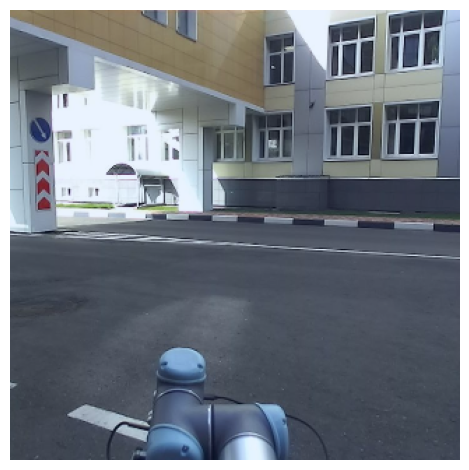

In [12]:
id_to_show = 1
ts.show(database_reader[id_to_show]["image_front_cam"])
print(f"Pose: {database_reader[id_to_show]['pose'].numpy()}")

## Инициализация модели


Сначала обычная модель для одиночных фреймов данных.

Здесь мы используем Bag-of-Queries (BoQ) с бэкбоном DINOv2.
О методе - https://github.com/amaralibey/Bag-of-Queries

In [13]:
model = BoQModel(backbone_name="dinov2")
# model = BoQModel(backbone_name="resnet50")
# model = NetVLADModel(backbone_name="vit_base_patch16_224", pretrained=True)

Downloading: "https://github.com/amaralibey/bag-of-queries/zipball/main" to /tmp/xdg_cache/torch/hub/main.zip
Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /tmp/xdg_cache/torch/hub/main.zip
INFO:dinov2:using MLP layer as FFN
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vitb14/dinov2_vitb14_pretrain.pth" to /tmp/xdg_cache/torch/hub/checkpoints/dinov2_vitb14_pretrain.pth
100%|██████████| 330M/330M [00:05<00:00, 68.7MB/s] 
Downloading: "https://github.com/amaralibey/Bag-of-Queries/releases/download/v1.0/dinov2_12288.pth" to /tmp/xdg_cache/torch/hub/checkpoints/dinov2_12288.pth
100%|██████████| 363M/363M [00:02<00:00, 129MB/s]  


Модели в OPR ожидают определенный формат входных данных:
- `images_<camera_name>` - батч изображений для камеры `<camera_name>`


In [14]:
sample_frame = database_reader[id_to_show]

img = sample_frame['image_front_cam'].unsqueeze(0)
batch = {
    'images_front_cam': img
}
print(batch["images_front_cam"].shape)

sample_output = model(batch)

torch.Size([1, 3, 322, 322])


**❗ Внимание:** `model.forward` ожидает на вход **батч** из словаря с ключами `images_<camera_name>` - размерность батча должна быть `(B, 3, H, W)`, где `B` - количество изображений в батче, `H` и `W` - высота и ширина изображений соответственно.

In [15]:
batch_size = 1
database_dl = torch.utils.data.DataLoader(
    database_reader,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=database_reader.collate_fn,
    drop_last=False,
)

sample_batch = next(iter(database_dl))
print(f"Batch sample keys: {sample_batch.keys()}")
print(f"Batch sample shapes: {[v.shape for v in sample_batch.values()]}")

Batch sample keys: dict_keys(['poses', 'images_front_cam'])
Batch sample shapes: [torch.Size([1, 2]), torch.Size([1, 3, 322, 322])]


In [16]:
sample_output = model(sample_batch)

print(f"Sample output keys: {sample_output.keys()}")
print(f"Sample output shapes: {[v.shape for v in sample_output.values()]}")
print(f"Sample descriptor shape: {sample_output['final_descriptor'].shape}")

Sample output keys: dict_keys(['final_descriptor'])
Sample output shapes: [torch.Size([1, 12288])]
Sample descriptor shape: torch.Size([1, 12288])


## Подготовка БД

Для использования пайплайна инференса OPR необходимо подготовить базу данных в формате `faiss` индекса

In [17]:
batch_size = 16
database_dl = torch.utils.data.DataLoader(
    database_reader,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=database_reader.collate_fn,
    drop_last=False,
    num_workers=4,
    pin_memory=True
)

In [18]:
database_dir = DATA_DIR / "test" / "database"
database_dir.mkdir(parents=True, exist_ok=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.eval()

descriptors_list = []
with torch.no_grad():
    for batch in tqdm(database_dl):
        batch = {k: v.to(device, non_blocking=True) for k, v in batch.items()}
        descriptors = model(batch)["final_descriptor"]
        descriptors_list.append(descriptors)

descriptors = torch.cat(descriptors_list, dim=0)
print(f"Descriptors shape: {descriptors.shape}")

# Create L2 distance FAISS index for nearest neighbor search
faiss_index = faiss.IndexFlatL2(descriptors.shape[1])
faiss_index.add(descriptors.cpu().numpy())
faiss.write_index(
    faiss_index,
    str(database_dir / "index.faiss")
)

# Copy pose data as track.csv (required by PlaceRecognitionPipeline)
shutil.copy(DATA_DIR / "test" / "07_2023-10-04-day" / "track.csv", database_dir / "track.csv")

  0%|          | 0/131 [00:00<?, ?it/s]

Descriptors shape: torch.Size([2096, 12288])


PosixPath('/home/jupyter/work/resources/iprofihack2025_phystech_cartography/data/test/database/track.csv')

## Sequence-based baseline

В качестве бейзлайна для обработки последовательностей предлагается использовать алгоритм **Candidate Pool Fusion**:

![candidate_pool_fusion](../images/candidate_pool_fusion.jpg)

См. код в `opr.pipelines.place_recognition.sequential`

## Чтение query данных

Для удобства напишем небольшой Wrapper, который будет читать несколько фреймов из исходного DataReader и возвращать их в виде последовательности

In [19]:
class TrackSeqWrapper:
    def __init__(self, 
                 track_data_reader: ITLPTrackDataReader, 
                 seq_len: int = 3, 
                 pad: bool = True):
        """Wrapper for ITLPTrackDataReader to provide sequences of specified length."""
        self.track_data_reader = track_data_reader
        self.seq_len = seq_len
        self.pad = pad

    def __len__(self) -> int:
        return len(self.track_data_reader)

    def __getitem__(self, idx: int) -> list[dict[str, Tensor]]:
        """Get a sequence of frames up to the given index."""
        start = max(0, idx - self.seq_len + 1)
        sequence = [self.track_data_reader[i] for i in range(start, idx + 1)]
        if self.pad and len(sequence) < self.seq_len:
            sequence = ([self.track_data_reader[0]]
                        * (self.seq_len - len(sequence)) + sequence)
        return sequence

In [20]:
query_reader = ITLPTrackDataReader(
    root=DATA_DIR / "test" / "08_2023-10-11-night",
    image_transform=setup_transforms(image_size=322),
)

seq_data_reader = TrackSeqWrapper(
    track_data_reader=query_reader,
    seq_len=3,
)

## Инференс

См. реализации в коде библиотеки OPR:
- `opr.models.place_recognition.sequential.SequenceLateFusionModel`
- `opr.modules.temporal.TemporalAveragePooling`


In [21]:
# from pathlib import Path

# import faiss
# import numpy as np
# import pandas as pd
# import torch
# from torch import nn, Tensor

# from opr.utils import parse_device, init_model


# def candidate_pool_fusion(
#     distances: np.ndarray, indices: np.ndarray
# ) -> tuple[np.ndarray, np.ndarray]:
#     query_len, _, at_n = distances.shape

#     # Initialize output arrays - use np.inf for unfilled distance slots
#     merged_distances = np.full((query_len, at_n), np.inf, dtype=distances.dtype)
#     merged_indices = np.full((query_len, at_n), -1, dtype=indices.dtype)

#     # Process each query independently to avoid memory explosion
#     for q in range(query_len):
#         # Step 1: Flatten all candidates from all sequence frames for this query
#         # This creates the "candidate pool" where each frame votes
#         all_distances = distances[q].flatten()  # shape: (seq_len * at_n,)
#         all_indices = indices[q].flatten()      # shape: (seq_len * at_n,)

#         # Step 2: Sort all candidates globally by embedding distance (ascending)
#         # This ensures the best candidates (smallest distances) come first
#         sort_order = np.argsort(all_distances)
#         sorted_distances = all_distances[sort_order]
#         sorted_indices = all_indices[sort_order]

#         # Step 3: Remove duplicates, keeping first occurrence (best distance)
#         # np.unique with return_index gives us the first occurrence of each unique index
#         unique_indices, first_positions = np.unique(
#             sorted_indices, return_index=True
#         )

#         # Extract the corresponding distances for the unique indices
#         unique_distances = sorted_distances[first_positions]

#         # Step 4: Re-sort by distance since np.unique doesn't preserve order
#         # This ensures our final ranking is still distance-ordered
#         final_sort_order = np.argsort(unique_distances)
#         final_indices = unique_indices[final_sort_order]
#         final_distances = unique_distances[final_sort_order]

#         # Step 5: Truncate to at_n and store results
#         final_count = min(len(final_indices), at_n)
#         merged_indices[q, :final_count] = final_indices[:final_count]
#         merged_distances[q, :final_count] = final_distances[:final_count]

#         # Note: Remaining slots in merged_distances stay as np.inf and
#         # merged_indices stay as -1, which should be handled appropriately

#     return merged_distances, merged_indices


# class SequencePlaceRecognitionPipeline:
#     def __init__(
#         self,
#         database_dir: Path,
#         model: nn.Module,
#         model_weights_path: Path | None = None,
#         device: str | int | torch.device = "cpu",
#         use_candidate_pool_fusion: bool = True,
#         at_n: int = 5,
#     ) -> None:
#         self.device = parse_device(device)
#         self.model = init_model(model, model_weights_path, self.device)
#         self.database_dir = Path(database_dir)
#         self._init_database(self.database_dir)
#         self.use_candidate_pool_fusion = use_candidate_pool_fusion
#         self.at_n = at_n

#     def _init_database(self, database_dir: Path) -> None:
#         """Initialize database."""
#         self.database_df = pd.read_csv(database_dir / "track.csv", index_col=0)
#         database_index_filepath = database_dir / "index.faiss"
#         if not database_index_filepath.exists():
#             raise FileNotFoundError(f"Database index not found: {database_index_filepath}. Create it first.")
#         self.database_index = faiss.read_index(str(database_index_filepath))

#     def _preprocess_input(self, input_data_sequence: list[dict[str, Tensor]]) -> dict[str, Tensor]:
#         if not input_data_sequence:
#             raise ValueError("Input data sequence cannot be empty")

#         seq_len = len(input_data_sequence)
#         out_dict: dict[str, Tensor] = {}

#         # Collect data from all frames
#         frame_data: dict[str, list[Tensor]] = {}

#         for _, input_data in enumerate(input_data_sequence):
#             for key in input_data:
#                 if key.startswith("image_"):
#                     new_key = f"images_{key[6:]}"
#                     if new_key not in frame_data:
#                         frame_data[new_key] = []
#                     frame_data[new_key].append(input_data[key].to(self.device))
#         # Stack all collected tensors along sequence dimension and add batch dimension
#         for key, tensor_list in frame_data.items():
#             stacked = torch.stack(tensor_list, dim=0)  # [seq_len, ...]
#             out_dict[key] = stacked.unsqueeze(0)  # [1, seq_len, ...]

#         return out_dict

#     def infer(self, input_data_sequence: list[dict[str, Tensor]]) -> dict[str, np.ndarray]:
#         input_data = self._preprocess_input(input_data_sequence)
#         output = {}

#         with torch.no_grad():
#             model_output = self.model(input_data)

#             if not self.use_candidate_pool_fusion:
#                 # Standard single descriptor approach
#                 descriptor = model_output["final_descriptor"].cpu().numpy().reshape(1, -1)
#                 _, pred_i = self.database_index.search(descriptor, 1)
#                 pred_i = pred_i[0][0]
#             else:
#                 # Candidate pool fusion approach
#                 _, sequential_descriptors = model_output["final_descriptor"]  # [1, seq_len, descriptor_dim]
#                 seq_descriptors_np = sequential_descriptors.cpu().numpy()  # [1, seq_len, descriptor_dim]

#                 # Search database for each frame's descriptor
#                 # Reshape to [seq_len, descriptor_dim] for FAISS search
#                 seq_descriptors_flat = seq_descriptors_np.reshape(-1, seq_descriptors_np.shape[-1])

#                 # Get top-K candidates for each frame
#                 frame_distances, frame_indices = self.database_index.search(seq_descriptors_flat, self.at_n)

#                 # Reshape results back to [1, seq_len, at_n] for candidate_pool_fusion
#                 frame_distances = frame_distances.reshape(1, -1, self.at_n)
#                 frame_indices = frame_indices.reshape(1, -1, self.at_n)

#                 # Apply candidate pool fusion
#                 fused_distances, fused_indices = candidate_pool_fusion(frame_distances, frame_indices)

#                 # Get the best candidate after fusion
#                 pred_i = fused_indices[0, 0]  # First (best) candidate from first (only) query

#         # Get pose for the predicted index
#         pred_pose = self.database_df.iloc[pred_i][['tx', 'ty']].to_numpy(
#             dtype=float
#         )

#         # Get final descriptor for output (always use the fused/final descriptor)
#         final_descriptor = model_output["final_descriptor"][0].cpu().numpy()[0]  # Remove batch dimension

#         output["idx"] = pred_i
#         output["pose"] = pred_pose
#         output["descriptor"] = final_descriptor
#         return output

In [22]:
import torch
import torch.nn as nn
from torch import Tensor

class TemporalWeightedAveragePooling(nn.Module):
    """
    Weighted average of features across the sequence, 
    с фиксированными линейно нарастающими весами (последний кадр важнее).
    """

    def forward(self, x: Tensor) -> tuple[Tensor, Tensor]:
        """
        Args:
            x: Tensor of shape [B, S, D] (B — batch, S — seq length, D — feature dim)

        Returns:
            - Tensor of shape [B, D]: взвешенное усреднение по S
            - Tensor of shape [B, S, D]: исходные фичи, умноженные на веса
        """
        B, S, D = x.shape
        # создаём вектор весов [1, S, 1]: [1, 1, ..., S] нормируем сумму в 1
        weights = torch.arange(1, S + 1, device=x.device, dtype=x.dtype)
        weights = weights / weights.sum()
        weights = weights.view(1, S, 1)

        # взвешиваем все фичи
        weighted_feats = x * weights        # [B, S, D]
        fused = weighted_feats.sum(dim=1)   # [B, D]

        return fused, weighted_feats

In [23]:
from opr.modules.temporal import (TemporalMaxPooling)

seq_model = SequenceLateFusionModel(
    model=model,
    temporal_fusion_module=TemporalWeightedAveragePooling(),
)

pipe = SequencePlaceRecognitionPipeline(
    database_dir=DATA_DIR / "test" / "database",
    model=seq_model,
    use_candidate_pool_fusion=True,
)

In [24]:
output_ids = []
for query_seq in tqdm(seq_data_reader):
    output = pipe.infer(query_seq)
    output_ids.append(output['idx'])

with open(SUBMISSIONS_DIR / "baseline3.txt", "w") as f:
    for idx in output_ids:
        f.write(f"{idx}\n")

print(f"Submissions saved to {SUBMISSIONS_DIR / 'baseline3.txt'}")

  0%|          | 0/2044 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [25]:
len(output_ids)

1236

In [26]:
with open("baseline3.txt", "w") as f:
    for idx in output_ids:
        f.write(f"{idx}\n")